## Q-Learning

In [1]:
#!pip install pygame gym[atari]==0.19.0 numpy 

     |████████████████████████████████| 21.8 MB 17.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 44.7 MB/s eta 0:00:01
     |████████████████████████████████| 790 kB 98.2 MB/s eta 0:00:01
     |████████████████████████████████| 60.9 MB 36.2 MB/s eta 0:00:01
Reason for being yanked: re-release with new wheels
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663120 sha256=10747621cf138fa6e69acf17953c5c5b37b375502a1b695131f3d03c62bbcb84
  Stored in directory: /root/.cache/pip/wheels/11/36/28/628f4dd3779e4037a6fca1aaed76827ffa4315c3ab6bfadcf6
  Created wheel for atari-py: filename=atari_py-0.2.6-cp38-cp38-linux_x86_64.whl size=3116258 sha256=96b6c2e879be6dcf97cb6b6f12fa28d4547f732dbd4cb9321dd1169a4b025769
  Stored in directory: /root/.cache/pip/wheels/7f/5e/27/2e90b9887063d82ee2f9f8b2f8db76bb2290aa281dc40449c8
Successfully built gym atari-py
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
requirements="""
                pygame
                gym==0.19.0
                numpy
            """

## Defining Environment

In [1]:
import gym
#env = gym.make("FrozenLake-v1")

from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)

env = gym.make('FrozenLakeNotSlippery-v0')

In [2]:
env.reset()

0

### Random Play

In [3]:
import numpy as np
def play_lake(n_games,win_ratio_eval=10):
    scores=[]
    win_ratios=[]
    for game in range(n_games):
        env.reset()
        game_over=False
        score=0
        while not game_over:
            action=env.action_space.sample() ##random action
            observation, reward, game_over, info = env.step(action)
            score+=reward
            
        scores.append(score)
    
        if game%win_ratio_eval==0:
            win_ratios.append(np.mean(scores[-win_ratio_eval:]))
        
    return win_ratios
            
            
    
plays=play_lake(1000)

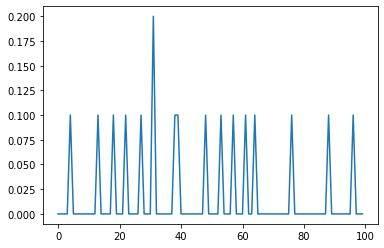

In [4]:
import matplotlib.pyplot as plt

g=plt.plot(plays)
plt.show()

### Now implement Q-learning  
![img](./images/Q-learning.png)

Define Agent

In [5]:
from dataclasses import dataclass
import numpy as np

##Course implementation

@dataclass
class Agent():
    lr:float=0.5
    gamma:float=0.95
    n_actions:int=4
    n_states:int=16
    epsilon:float=0.5
    eps_dec:float=0.9999995
    eps_min:float=0.01
    Q={}
    
    def init_Q(self):
        for state in range(self.n_states):
            for action in range(self.n_actions):
                self.Q[(state,action)]=0.0
                
    def __post_init__(self):
        self.init_Q()

    def random_action(self):
        return np.random.choice([i for i in range(self.n_actions)])
    
        
    def choose_action(self,state):
        if np.random.random() < self.epsilon:
            action=self.random_action()
        else:
            actions=np.array([self.Q[(state,a)] for a in range(self.n_actions)])
            action=np.argmax(actions)
        return action
    
    ## if using only greedy algorithm
    def choose_action_greedy(self,state):
        actions=np.array([self.Q[(state,a)] for a in range(self.n_actions)])
        if np.max(actions)>0:
            return np.argmax(actions)
        else:
            return self.random_action()
    
    def decrease_epsilon(self):
        self.epsilon=max(self.epsilon*self.eps_dec,self.eps_min)
        
    def learn(self,state,action,reward,state_):
        actions= np.array([self.Q[(state_,a)] for a in range(self.n_actions)])
        a_max=np.argmax(actions)
        self.Q[(state,action)]=self.Q[(state,action)] + self.lr*(reward+self.gamma*self.Q[(state_,a_max)]-self.Q[(state,action)])
        self.decrease_epsilon()

In [16]:
## the same but using numpy for Q

import numpy as np

@dataclass
class Agent():
    lr:float=0.5
    gamma:float=0.95
    n_actions:int=4
    n_states:int=16
    epsilon:float=0.5
    eps_dec:float=0.9999995
    eps_min:float=0.01
    Q={}
    
    def init_Q(self):
        self.Q = np.zeros((self.n_states, self.n_actions))
                
    def __post_init__(self):
        self.init_Q()

    def random_action(self):
        return np.random.choice([i for i in range(self.n_actions)])
    
        
    def choose_action(self,state):
        if np.random.random() < self.epsilon:
            action=self.random_action()
        else:
            actions=self.Q[state]
            action=np.argmax(actions)
        return action
    
    ## if using only greedy algorithm
    def choose_action_greedy(self,state):
        actions=self.Q[state]
        if np.max(actions)>0:
            return np.argmax(actions)
        else:
            return self.random_action()
    
    def decrease_epsilon(self):
        self.epsilon=max(self.epsilon*self.eps_dec,self.eps_min)
        
    def learn(self,state,action,reward,state_):
        actions=self.Q[state_]
        a_max=np.argmax(actions)
        self.Q[state,action]=self.Q[state,action]+self.lr*(reward+self.gamma*np.max(actions)-self.Q[state,action])
        self.decrease_epsilon()

In [35]:
## method to play n_games given an agent
agent_lake=Agent(lr=0.001,gamma=0.90,n_actions=4,n_states=16,epsilon=1.0)

def play_lake(env_game,agent,n_games,win_ratio_eval=100,eval_learning_steps=1000):
    scores=[]
    win_ratios=[]
    for game in range(n_games):
        state=env_game.reset()
        game_over=False
        score=0
        while not game_over:
            #action=agent.choose_action(state)
            action=agent.choose_action_greedy(state)
            new_state, reward, game_over, info = env_game.step(action)
            agent.learn(state,action,reward,new_state)
            score+=reward
            state=new_state
            
        scores.append(score)
        if game%win_ratio_eval==0:
            win_rt=np.mean(scores[-win_ratio_eval:])
            win_ratios.append(win_rt)
            if game % eval_learning_steps==0:
                print(f"Episode {game} | Win Percentage {win_rt:.3%} | Epsilon {agent.epsilon:.3f}")
    return win_ratios,scores

In [18]:
print("Q matrix before training")
agent_lake.Q

Q matrix before training


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [36]:
N_GAMES=1000
results=play_lake(env,agent_lake,N_GAMES,10,100)

Episode 0 | Win Percentage 0.000% | Epsilon 1.000
Episode 100 | Win Percentage 100.000% | Epsilon 1.000
Episode 200 | Win Percentage 100.000% | Epsilon 0.999
Episode 300 | Win Percentage 100.000% | Epsilon 0.999
Episode 400 | Win Percentage 100.000% | Epsilon 0.999
Episode 500 | Win Percentage 100.000% | Epsilon 0.998
Episode 600 | Win Percentage 100.000% | Epsilon 0.998
Episode 700 | Win Percentage 100.000% | Epsilon 0.998
Episode 800 | Win Percentage 100.000% | Epsilon 0.998
Episode 900 | Win Percentage 100.000% | Epsilon 0.997


In [22]:
print("Q matrix After training")
agent_lake.Q

Q matrix After training


array([[0.00000000e+00, 2.14857611e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.18554200e-12, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.61559340e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.05097638e-08, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.02109538e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.24526355e-02, 0.00000000e+00],
       [0.00000000e+00, 2.08705709e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e

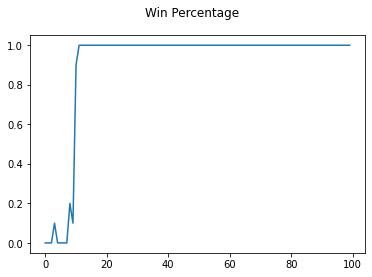

In [33]:
f,ax=plt.subplots();
ax=plt.plot(results[0])
f.suptitle('Win Percentage', fontsize=12);

## What if we add slippery to the game? This adds some randomness to the movement

In [11]:
env_slip=gym.make("FrozenLake-v1")

In [37]:
agent_lake=Agent(lr=0.01,gamma=0.95,n_actions=4,n_states=16,epsilon=1.0)
N_GAMES=100000
results=play_lake(env_slip,agent_lake,N_GAMES,10,1000)


Episode 0 | Win Percentage 0.000% | Epsilon 1.000
Episode 1000 | Win Percentage 0.000% | Epsilon 0.996
Episode 2000 | Win Percentage 10.000% | Epsilon 0.991
Episode 3000 | Win Percentage 0.000% | Epsilon 0.987
Episode 4000 | Win Percentage 0.000% | Epsilon 0.983
Episode 5000 | Win Percentage 0.000% | Epsilon 0.978
Episode 6000 | Win Percentage 10.000% | Epsilon 0.974
Episode 7000 | Win Percentage 0.000% | Epsilon 0.970
Episode 8000 | Win Percentage 10.000% | Epsilon 0.965
Episode 9000 | Win Percentage 10.000% | Epsilon 0.961
Episode 10000 | Win Percentage 0.000% | Epsilon 0.957
Episode 11000 | Win Percentage 0.000% | Epsilon 0.952
Episode 12000 | Win Percentage 10.000% | Epsilon 0.948
Episode 13000 | Win Percentage 10.000% | Epsilon 0.944
Episode 14000 | Win Percentage 10.000% | Epsilon 0.940
Episode 15000 | Win Percentage 0.000% | Epsilon 0.936
Episode 16000 | Win Percentage 0.000% | Epsilon 0.932
Episode 17000 | Win Percentage 10.000% | Epsilon 0.928
Episode 18000 | Win Percentage 10

In [49]:
print(f"Max win Percentage {max(results[0]):.2%}")

Max win Percentage 30.00%


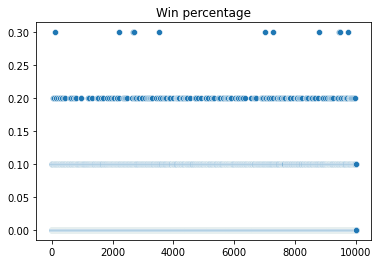

In [47]:
import seaborn as sns
f,ax=plt.subplots();
ax=sns.scatterplot(x=range(len(results[0])),y=results[0])
ax.set_title("Win percentage");